# USSA – Junior Quant Researcher – Case Study

**Purpose:** As part of the next stage in the interview process, we’d like you to embark on a case study aimed at developing trading strategies and predictions. This project will involve the creation of a brief report along with your code (preferably in Python but could be in any other programming languages). We have left this open-ended, as such the focus of your project could encompass thematic investments, specific sectors, industries, or even individual stocks.
Objectives: We would like to see data pre-process, modeling, and validation from this case study

**Data:** 
- We would like to see how you can gather and pre-process data turning into useful features/signals. 
- Please feel free to use any sort of data, such as pre-existing stock factors, macro values, news, climate, etc. 
- Please explain why you chose these data sources. 

**Modeling:**
- You may apply any statistical/ML models you think the most suitable. 
- Please explain why you chose that specific model(s).

**Validation:**
- Show us how you have tested your model and data. 
- Please share with us how significant they are, even if the significance is minimal. 
- Provide insights as to why they are/aren’t expected, and what can be improved. 

To reiterate, this project is designed to be open-ended. We are NOT going to evaluate purely the performance of your strategy, or significance of your model and data. Rather, we would like to see your approach and the steps you’ve taken to initiate and complete the project. 

### PAIR TRADING STRATEGY

We will use the Nasdap 100 list of companies as a universe for our strategy. More specifically, we will use the data from '2015-01-01' to '2021-01-01' to identify a pair and train XGBoost models to predict the price of the stocks before implementing the strategy. 

1. Retrieve Data: We will use Yahoo Finance as a provider for our data.
2. Data Processing: Clean the data if needed, remove the stocks not traded before '2015-01-01' and interpolate potential missing data.
3. Identification of Pairs: The first step of building the strategy is to identify two closely related securities, often two stocks operating within the same sector. These stocks should have a high historical correlation. In order to do that we will perform a cointegration test. Based on the results on our universe, we will select the pair that have potential.
4. XGBoost Models: XGBoost models have the ability to handle a variety of data types, capture complex patterns, and provide robust and accurate predictions. Its gradient boosting framework can effectively model time-dependent structures and its built-in regularization parameter helps to prevent overfitting, making it a popular choice for financial time series forecasting.
5. Implement the Strategy: The strategy is based on the assumption that the price difference between the paired securities tends to revert to its historical average. When the prices of paired stocks move away from each other (diverge), this strategy assumes that they will eventually converge back to their mean.

### STEP 0: Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Retrieve and Manipulate Data
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# Plot Results
import seaborn as sns
import matplotlib.pyplot as plt

# Perform Cointegration and Pairing
from statsmodels.tsa.stattools import coint
from itertools import combinations

# Build and validate the model
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math

### STEP 1: Retrieve Data

In this part, we will use the Nasdaq 100 list of stocks as our universe. We will retrieve the Adjusted Close Price between '2015-01-01' and '2021-01-01'.

In [2]:
def get_nasdaq100_tickers():
    # URL of the NASDAQ 100 companies list
    url = 'https://stockanalysis.com/list/nasdaq-100-stocks/'

    # Send a GET request
    response = requests.get(url)

    # Parse the HTML content of the page with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the table with the list of companies
    table = soup.find('table')

    # Read the table with pandas
    df = pd.read_html(str(table))[0]

    # Get the 'Symbol' column
    tickers = df['Symbol'].tolist()

    return tickers

# Get the NASDAQ 100 tickers
nasdaq100_tickers = get_nasdaq100_tickers()

print(nasdaq100_tickers)

['MSFT', 'AAPL', 'NVDA', 'GOOG', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'ASML', 'COST', 'AMD', 'NFLX', 'PEP', 'ADBE', 'AZN', 'CSCO', 'TMUS', 'QCOM', 'INTC', 'INTU', 'AMAT', 'CMCSA', 'PDD', 'TXN', 'AMGN', 'MU', 'ISRG', 'HON', 'LRCX', 'BKNG', 'VRTX', 'ABNB', 'REGN', 'ADP', 'SBUX', 'ADI', 'KLAC', 'MDLZ', 'GILD', 'PANW', 'SNPS', 'CDNS', 'CRWD', 'MELI', 'MAR', 'CSX', 'WDAY', 'PYPL', 'CTAS', 'ORLY', 'PCAR', 'MRVL', 'NXPI', 'CEG', 'MNST', 'ROP', 'DASH', 'CPRT', 'ADSK', 'FTNT', 'DXCM', 'TEAM', 'ROST', 'MCHP', 'ODFL', 'LULU', 'KHC', 'AEP', 'FAST', 'PAYX', 'IDXX', 'KDP', 'TTD', 'DDOG', 'GEHC', 'CHTR', 'MRNA', 'CSGP', 'EXC', 'CTSH', 'FANG', 'EA', 'CDW', 'BKR', 'VRSK', 'CCEP', 'BIIB', 'ON', 'ANSS', 'XEL', 'DLTR', 'ZS', 'GFS', 'TTWO', 'MDB', 'WBD', 'ILMN', 'WBA', 'SIRI']


In [3]:
data = yf.download(nasdaq100_tickers, start='2015-01-01', end='2021-01-01')['Adj Close']

[*********************100%%**********************]  100 of 100 completed


6 Failed downloads:
['GEHC', 'CEG', 'GFS']: Exception("%ticker%: Data doesn't exist for startDate = 1420088400, endDate = 1609477200")
['MU', 'CSX', 'TMUS']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-01-01 -> 2021-01-01)')


In [4]:
data.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00,24.435274,NaN,72.339996,45.635731,68.093727,59.529999,44.049953,22.116617,2.67,122.898582,...,NaN,28.100000,41.677044,61.820881,123.070000,55.410770,34.480000,80.410004,27.094414,NaN
2015-01-05 00:00:00,23.746889,NaN,71.980003,44.805840,68.044693,58.660000,43.401623,21.407749,2.66,121.438133,...,NaN,27.620001,41.030228,61.018761,121.029999,54.317135,33.060001,80.010002,26.786867,NaN
2015-01-06 00:00:00,23.749126,NaN,70.529999,43.754097,67.480545,57.500000,43.639343,20.601414,2.63,117.525742,...,NaN,27.930000,40.352249,60.806156,117.360001,54.455662,31.980000,79.419998,26.929386,NaN
2015-01-07 00:00:00,24.082136,NaN,71.110001,44.214230,68.069221,57.380001,44.258862,20.796352,2.58,121.630318,...,NaN,28.100000,41.076996,60.844799,120.660004,55.848232,32.209999,79.349998,27.161924,NaN
2015-01-08 00:00:00,25.007431,NaN,72.919998,44.994835,69.630722,58.799999,44.640648,21.460909,2.61,121.192162,...,NaN,28.459999,41.747200,61.453636,123.970001,56.540848,32.470001,82.779999,27.476982,NaN


### STEP 2: Data Processing

Since we are using a large universe, we will not introduce any potential misleading interpolation in our data as we will be using cointegration in the following steps. However, there are several way to compute missing data. 

In [5]:
data = data.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
tickers = data.columns.tolist()

In [6]:
data

,AAPL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,AMZN,...,SNPS,TSLA,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.435274,72.339996,45.635731,68.093727,59.529999,44.049953,22.116617,2.670000,122.898582,15.426000,...,43.099998,14.620667,28.100000,41.677044,61.820881,123.070000,55.410770,34.480000,80.410004,27.094414
2015-01-05,23.746889,71.980003,44.805840,68.044693,58.660000,43.401623,21.407749,2.660000,121.438133,15.109500,...,42.540001,14.006000,27.620001,41.030228,61.018761,121.029999,54.317135,33.060001,80.010002,26.786867
2015-01-06,23.749126,70.529999,43.754097,67.480545,57.500000,43.639343,20.601414,2.630000,117.525742,14.764500,...,42.160000,14.085333,27.930000,40.352249,60.806156,117.360001,54.455662,31.980000,79.419998,26.929386
2015-01-07,24.082136,71.110001,44.214230,68.069221,57.380001,44.258862,20.796352,2.580000,121.630318,14.921000,...,42.209999,14.063333,28.100000,41.076996,60.844799,120.660004,55.848232,32.209999,79.349998,27.161924
2015-01-08,25.007431,72.919998,44.994835,69.630722,58.799999,44.640648,21.460909,2.610000,121.192162,15.023000,...,42.860001,14.041333,28.459999,41.747200,61.453636,123.970001,56.540848,32.470001,82.779999,27.476982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,129.514481,499.859985,136.212601,165.298676,301.390015,72.187897,83.037605,91.809998,201.025848,158.634506,...,256.279999,220.589996,202.500000,147.743729,197.072845,234.460007,33.645584,28.570000,248.759995,58.505474
2020-12-28,134.146622,498.950012,136.410583,165.345459,299.649994,72.063759,82.589966,91.599998,201.675064,164.197998,...,256.160004,221.229996,201.119995,147.588379,203.683411,232.470001,33.679550,29.450001,241.919998,59.130089
2020-12-29,132.360489,502.109985,135.448898,163.716446,298.109985,71.975113,82.006088,90.620003,204.578674,166.100006,...,253.820007,221.996674,202.449997,147.323288,201.421143,233.490005,33.467243,29.690001,237.720001,59.220608


In [7]:
# Count the number of remaining NaN values in the dataframe 
nan_count = data.isna().sum().sum()
print(nan_count)

0


In [8]:
adj_close_data = np.column_stack([data[ticker].values for ticker in tickers])

### STEP 3: Identification of Pairs

Quantitative analysts, or quants, identify potential trading opportunities by examining the cointegration relationship between assets. They issue buy and sell orders when the spread between these assets deviates from its historical average, with the expectation that the spread will eventually return to its long-term equilibrium.

The following code will explore the selected set of stocks, to uncover any concealed relationships.

The code tests a statistical concept known as the Null Hypothesis ($H_0$), which assumes the absence of any effect or relationship. Generally, if the p-value falls below $0.02$, the $H_0$ is rejected, indicating a significant relationship between the pair.

In [9]:
p_value_threshold = 0.02

n = len(tickers)
pvalue_matrix = np.ones((n, n))
for i, j in combinations(range(n), 2):
    result = coint(adj_close_data[:, i], adj_close_data[:, j])
    pvalue_matrix[i, j] = result[1]

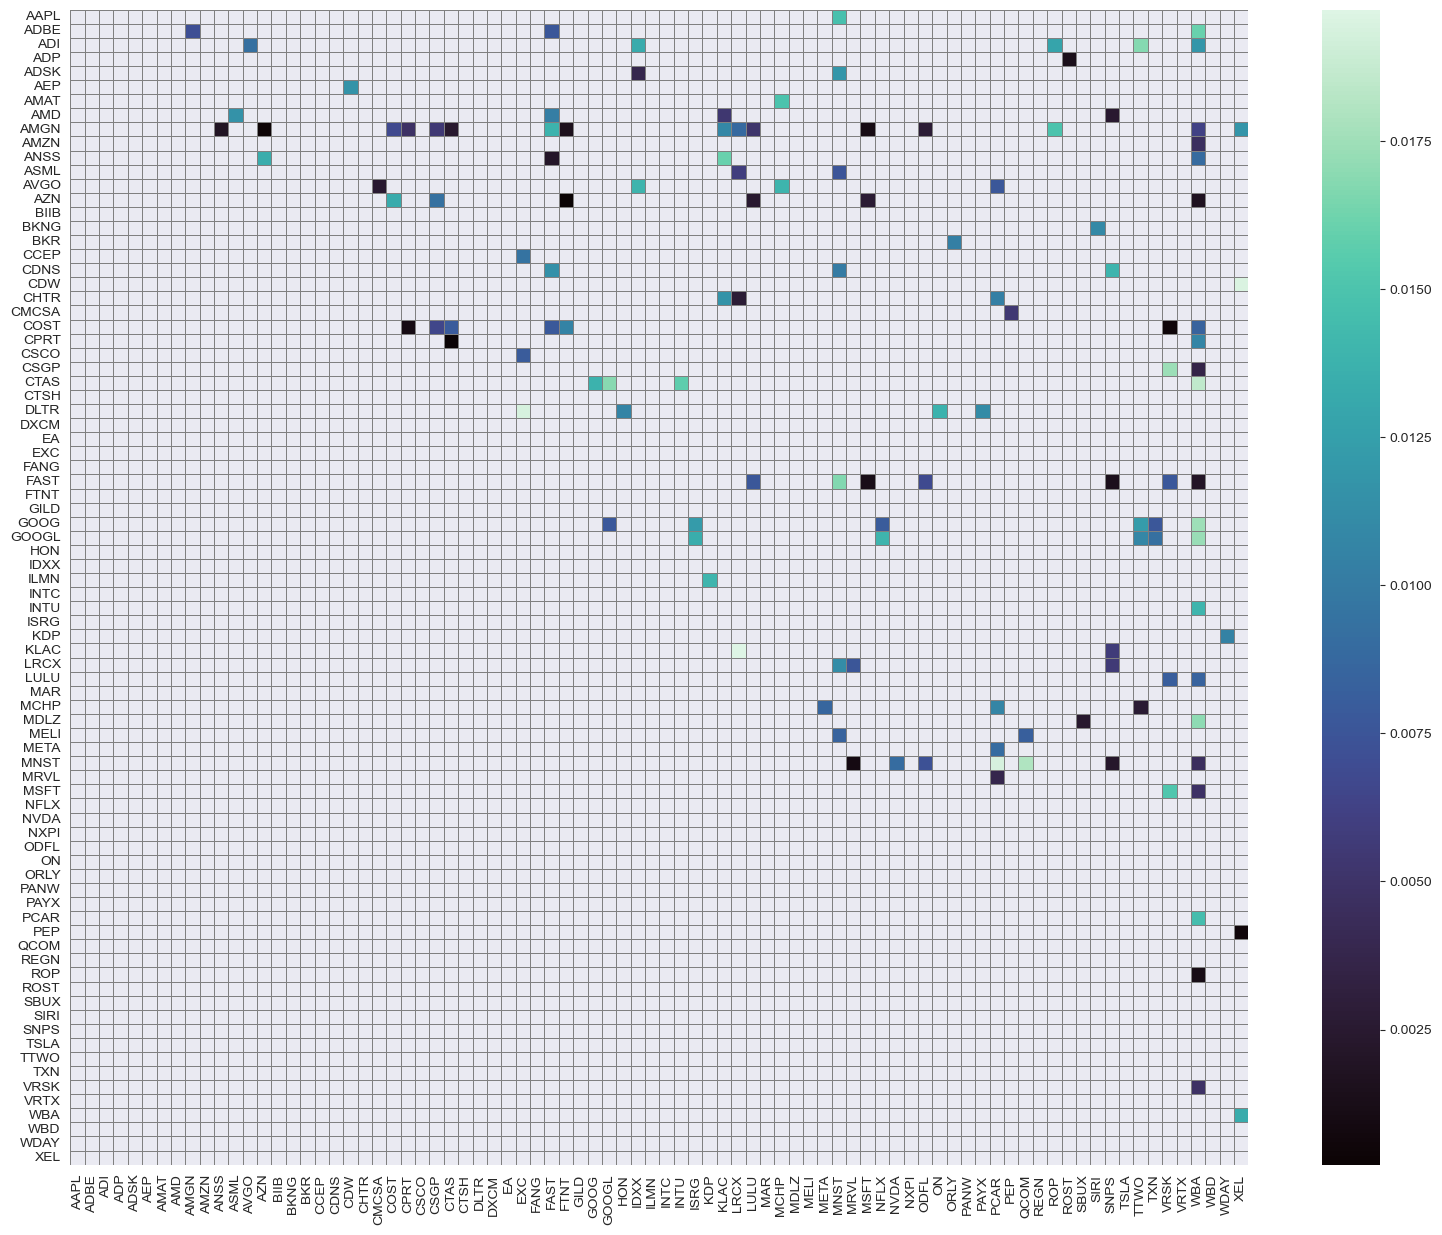

In [10]:
plt.figure(figsize=(19, 15))
heatmap = sns.heatmap(pvalue_matrix, xticklabels=tickers,
                      yticklabels=tickers, cmap='mako',
                      mask=(pvalue_matrix > p_value_threshold),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=10)
plt.show()

As stated above, the smaller the p-value is, the greater is the  long-term relation between the two stocks. We can see from this map the pairs that have a p-value inferior to the threshold. Let's find the pair that have a smallest p-value and perform the strategy on it. 

In [11]:
# Retrieve the pairs that respect the p_value_threshold 
pairs = [(tickers[i], tickers[j], pvalue_matrix[i, j]) for i, j in zip(*np.where(pvalue_matrix < p_value_threshold))]

sorted_pairs = sorted(pairs, key= lambda x: x[2])
sorted_pairs= sorted_pairs[:10]
sorted_pairs_labels, pairs_p_values = zip(*[(f'{y1} - {y2}', p*100) for y1, y2, p in sorted_pairs])

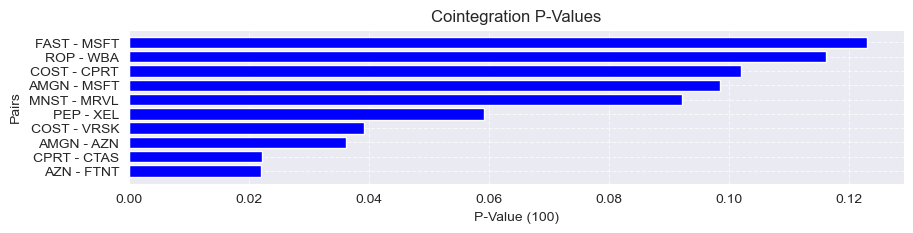

In [12]:
# Plot the 10 most cointegrated pairs
plt.figure(figsize=(10, 2))
plt.barh(sorted_pairs_labels, pairs_p_values, color='blue')
plt.xlabel('P-Value (100)')
plt.ylabel('Pairs')
plt.title('Cointegration P-Values')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

In order to implement our strategy we will select the pair that have the smallest p-value. In this case, we will use 'AZN' and 'FTNT'. 

### STEP 4: XGBoost Models

XGBoost models have the ability to handle a variety of data types, capture complex patterns, and provide robust and accurate predictions. Its gradient boosting framework can effectively model time-dependent structures and its built-in regularization parameter helps to prevent overfitting, making it a popular choice for financial time series forecasting. We will use the data from '2015-01-01' to '2021-01-01', as data to train our model, then we will test our models on the remaining data until today. 

To validate our models, we will use a Mean Square Error metric, with the objective of minimizing it, on both the training set and the test set: 
$$ MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

We will then use the prediction of our models to generate trading signals. 

#### STEP 4.1: AZN Prediction Model

In [13]:
# Download the AZN data, including Adj Close, Volume, Open, Close, High, and Low
data_AZN = yf.download('AZN', start='2015-01-01', end='2024-04-01')

[*********************100%%**********************]  1 of 1 completed


In [14]:
data_AZN = data_AZN.reset_index()
data_AZN.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,35.535000,35.610001,35.150002,35.200001,25.526253,1593400
1,2015-01-05,35.154999,35.174999,34.674999,34.930000,25.330450,2976800
2,2015-01-06,34.595001,34.779999,33.810001,34.080002,24.714054,4995600
3,2015-01-07,33.950001,34.139999,33.730000,34.044998,24.688667,3035400
4,2015-01-08,34.270000,34.755001,34.244999,34.535000,25.044006,4312200


In [15]:
data_AZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2325 non-null   datetime64[ns]
 1   Open       2325 non-null   float64       
 2   High       2325 non-null   float64       
 3   Low        2325 non-null   float64       
 4   Close      2325 non-null   float64       
 5   Adj Close  2325 non-null   float64       
 6   Volume     2325 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 127.3 KB


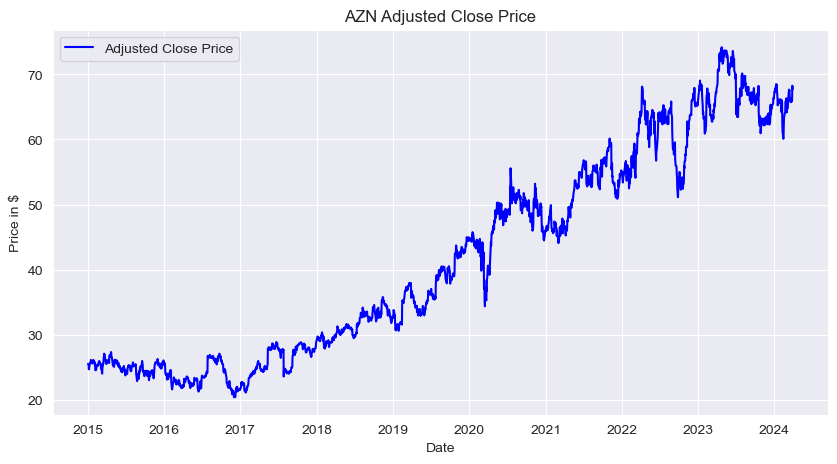

In [16]:
# Plot the data
plt.figure(figsize=(10,5))
plt.plot(data_AZN['Date'], data_AZN['Adj Close'], label='Adjusted Close Price', color='blue')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('AZN Adjusted Close Price')
plt.legend()
plt.show()

In [17]:
# Checking for any missing value in the dataset
missing_values = data_AZN.isnull().sum()
print(missing_values)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [18]:
# Compute the difference between high and low for each day
data_AZN['range_hl'] = data_AZN['High'] - data_AZN['Low']
# Compute the difference between open and close of each day
data_AZN['range_oc'] = data_AZN['Open'] - data_AZN['Close']
# Add an second index column to create the lags
data_AZN['Index'] = data_AZN.index
data_AZN.drop(['High', 'Low', 'Open', 'Close'], axis=1, inplace=True)
data_AZN.head()

,Date,Adj Close,Volume,range_hl,range_oc,Index
0,2015-01-02,25.526253,1593400,0.459999,0.334999,0
1,2015-01-05,25.330450,2976800,0.500000,0.224998,1
2,2015-01-06,24.714054,4995600,0.969997,0.514999,2
3,2015-01-07,24.688667,3035400,0.410000,-0.094997,3
4,2015-01-08,25.044006,4312200,0.510002,-0.264999,4


In order to predict the next price of the stock, we will use the previous data from the past $3$ days. 

In [19]:
# List of columns that we will use to create lags
lag_cols = ['Adj Close', 'Volume', 'range_hl', 'range_oc']
shift_range = [x + 1 for x in range(3)]

for shift in shift_range:
    train_shift = data_AZN[['Index'] + lag_cols].copy()

    train_shift['Index'] = train_shift['Index'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    data_AZN = pd.merge(data_AZN, train_shift, on='Index', how='left')

del train_shift

# Remove the first 3 rows which contain NaNs
data_AZN = data_AZN[3:]
data_AZN.head()

,Date,Adj Close,Volume,range_hl,range_oc,Index,Adj Close_lag_1,Volume_lag_1,range_hl_lag_1,range_oc_lag_1,Adj Close_lag_2,Volume_lag_2,range_hl_lag_2,range_oc_lag_2,Adj Close_lag_3,Volume_lag_3,range_hl_lag_3,range_oc_lag_3
3,2015-01-07,24.688667,3035400,0.410000,-0.094997,3,24.714054,4995600.0,0.969997,0.514999,25.330450,2976800.0,0.500000,0.224998,25.526253,1593400.0,0.459999,0.334999
4,2015-01-08,25.044006,4312200,0.510002,-0.264999,4,24.688667,3035400.0,0.410000,-0.094997,24.714054,4995600.0,0.969997,0.514999,25.330450,2976800.0,0.500000,0.224998
5,2015-01-09,25.178167,3737200,0.290001,0.119999,5,25.044006,4312200.0,0.510002,-0.264999,24.688667,3035400.0,0.410000,-0.094997,24.714054,4995600.0,0.969997,0.514999
6,2015-01-12,25.667658,3322800,0.544998,-0.020000,6,25.178167,3737200.0,0.290001,0.119999,25.044006,4312200.0,0.510002,-0.264999,24.688667,3035400.0,0.410000,-0.094997
7,2015-01-13,25.656782,2569000,0.830002,0.430000,7,25.667658,3322800.0,0.544998,-0.020000,25.178167,3737200.0,0.290001,0.119999,25.044006,4312200.0,0.510002,-0.264999


In [20]:
data_AZN = data_AZN.reset_index()
data_AZN.drop(['index', 'Index'], axis=1, inplace=True)
## Add moving average and moving std
cols_list = ["Adj Close", "range_hl", "range_oc", "Volume"]
for col in cols_list:
    data_AZN[col + '_mean'] = data_AZN[col].rolling(window=3, min_periods=1, center=False).mean()
    data_AZN[col + '_std'] = data_AZN[col].rolling(window=3, min_periods=1, center=False).std()
data_AZN.head()

,Date,Adj Close,Volume,range_hl,range_oc,Adj Close_lag_1,Volume_lag_1,range_hl_lag_1,range_oc_lag_1,Adj Close_lag_2,...,range_hl_lag_3,range_oc_lag_3,Adj Close_mean,Adj Close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,Volume_mean,Volume_std
0,2015-01-07,24.688667,3035400,0.410000,-0.094997,24.714054,4995600.0,0.969997,0.514999,25.330450,...,0.459999,0.334999,24.688667,NaN,0.410000,NaN,-0.094997,NaN,3.035400e+06,NaN
1,2015-01-08,25.044006,4312200,0.510002,-0.264999,24.688667,3035400.0,0.410000,-0.094997,24.714054,...,0.500000,0.224998,24.866337,0.251263,0.460001,0.070712,-0.179998,0.120210,3.673800e+06,902833.938219
2,2015-01-09,25.178167,3737200,0.290001,0.119999,25.044006,4312200.0,0.510002,-0.264999,24.688667,...,0.969997,0.514999,24.970280,0.252941,0.403334,0.110152,-0.079999,0.192937,3.694933e+06,639448.522817
3,2015-01-12,25.667658,3322800,0.544998,-0.020000,25.178167,3737200.0,0.290001,0.119999,25.044006,...,0.410000,-0.094997,25.296611,0.328263,0.448334,0.138232,-0.055000,0.194871,3.790733e+06,496867.641665
4,2015-01-13,25.656782,2569000,0.830002,0.430000,25.667658,3322800.0,0.544998,-0.020000,25.178167,...,0.510002,-0.264999,25.500869,0.279521,0.555000,0.270139,0.176666,0.230290,3.209667e+06,592260.224338


Now that the data is ready, we can split the dataset into a training set and a test set as defined previously. 

In [21]:
date = '2021-01-04'
train_end = data_AZN[data_AZN['Date'] == date].index.item()

# Split the DataFrame
train_AZN = data_AZN.iloc[:train_end]
test_AZN = data_AZN.iloc[train_end:]

print(f"Train set size: {train_AZN.shape}")
print(f"Test set size: {test_AZN.shape}")

Train set size: (1508, 25)
Test set size: (814, 25)


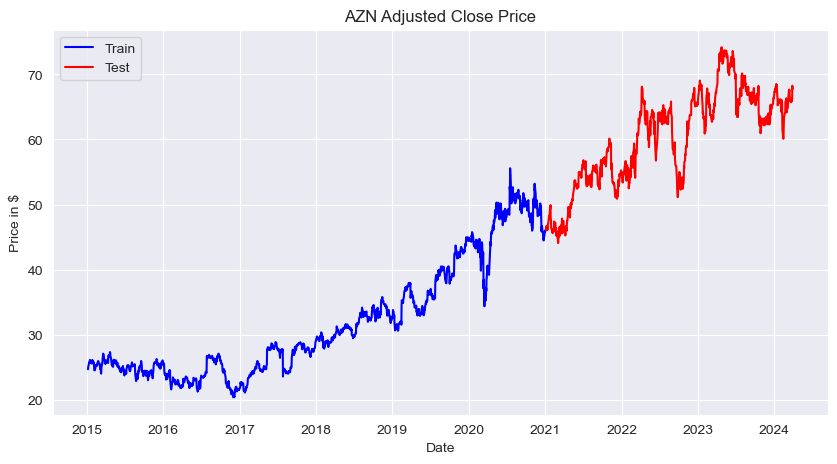

In [22]:
# Plot the data
plt.figure(figsize=(10,5))
plt.plot(train_AZN['Date'], train_AZN['Adj Close'], label='Train', color='blue')
plt.plot(test_AZN['Date'], test_AZN['Adj Close'], label='Test', color='red')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('AZN Adjusted Close Price')
plt.legend()
plt.show()

In [23]:
scaled_columns = ["Adj Close"]
for i in range(1,4):
    scaled_columns.append("Adj Close_lag_"+str(i))
    scaled_columns.append("range_hl_lag_"+str(i))
    scaled_columns.append("range_oc_lag_"+str(i))
    scaled_columns.append("Volume_lag_"+str(i))

In [24]:
scaler_train_AZN = StandardScaler()
train_AZN_scaled = scaler_train_AZN.fit_transform(train_AZN[scaled_columns])
train_AZN_scaled = pd.DataFrame(train_AZN_scaled, columns=scaled_columns)
train_AZN_scaled['Date'] = train_AZN['Date']

train_AZN_scaled.head()

,Adj Close,Adj Close_lag_1,range_hl_lag_1,range_oc_lag_1,Volume_lag_1,Adj Close_lag_2,range_hl_lag_2,range_oc_lag_2,Volume_lag_2,Adj Close_lag_3,range_hl_lag_3,range_oc_lag_3,Volume_lag_3,Date
0,-0.814687,-0.810696,0.975369,1.237479,0.134426,-0.739057,-0.131745,0.544743,-0.446792,-0.715570,-0.225317,0.808954,-0.847449,2015-01-07
1,-0.774023,-0.813603,-0.343766,-0.219888,-0.430906,-0.809691,0.975383,1.237632,0.136956,-0.738023,-0.131070,0.545900,-0.445699,2015-01-08
2,-0.758669,-0.772913,-0.108200,-0.626047,-0.062670,-0.812600,-0.343750,-0.219813,-0.429848,-0.808705,0.976295,1.239404,0.140575,2015-01-09
3,-0.702653,-0.757549,-0.626437,0.293768,-0.228503,-0.771881,-0.108184,-0.625993,-0.060653,-0.811616,-0.343120,-0.219334,-0.428682,2015-01-12
4,-0.703897,-0.701497,-0.025763,-0.040710,-0.348018,-0.756508,-0.626420,0.293871,-0.226918,-0.770869,-0.107504,-0.625874,-0.057889,2015-01-13


In [25]:
# Split into features and target
features = []
for i in range(1, 4):
    features.append("Adj Close_lag_" + str(i))
    features.append("range_hl_lag_" + str(i))
    features.append("range_oc_lag_" + str(i))
    features.append("Volume_lag_" + str(i))

target = "Adj Close"

# Split into X and y
X_train_AZN_scaled = train_AZN_scaled[features]
y_train_AZN_scaled = train_AZN_scaled[target]

X_train_AZN_scaled.head()

,Adj Close_lag_1,range_hl_lag_1,range_oc_lag_1,Volume_lag_1,Adj Close_lag_2,range_hl_lag_2,range_oc_lag_2,Volume_lag_2,Adj Close_lag_3,range_hl_lag_3,range_oc_lag_3,Volume_lag_3
0,-0.810696,0.975369,1.237479,0.134426,-0.739057,-0.131745,0.544743,-0.446792,-0.715570,-0.225317,0.808954,-0.847449
1,-0.813603,-0.343766,-0.219888,-0.430906,-0.809691,0.975383,1.237632,0.136956,-0.738023,-0.131070,0.545900,-0.445699
2,-0.772913,-0.108200,-0.626047,-0.062670,-0.812600,-0.343750,-0.219813,-0.429848,-0.808705,0.976295,1.239404,0.140575
3,-0.757549,-0.626437,0.293768,-0.228503,-0.771881,-0.108184,-0.625993,-0.060653,-0.811616,-0.343120,-0.219334,-0.428682
4,-0.701497,-0.025763,-0.040710,-0.348018,-0.756508,-0.626420,0.293871,-0.226918,-0.770869,-0.107504,-0.625874,-0.057889


We can now define our model and use the *GridSearchCV* function to find the best parameters. *GridSearchCV* works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance.
The benefits of using this function  are:
1. Efficiency: It saves a lot of time. Manually tuning parameters is time-consuming, and the amount of time increases exponentially with the number of parameters.
2. Optimization: It helps to find the optimal parameters for the model which results in the most accurate predictions.
3. Cross-Validation: During this process, it performs cross-validation internally. The data set is split into $k$ ‘folds’ and it trains the model $k$ times, each time leaving a different fold out of the training set and using it as the test set. This gives a more robust measure of the quality of the model.

Because of limited computer power, we will look at only $3$ parameters: 
- n_estimators
- max_depth
- learning_rate

In [26]:
#Define the model
model = XGBRegressor(objective ='reg:squarederror')

# Define the parameters to tune
param_grid = {
    'n_estimators': range(30, 130, 10),
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
}

# Initialize Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')


# Assuming X_train and y_train are your data
grid.fit(X_train_AZN_scaled, y_train_AZN_scaled)

# Print the best parameters
print("Best parameters found: ", grid.best_params_)
print("Best MSE score: ", -grid.best_score_)

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 70}
Best MSE score:  0.3609999778722858


We have the best parameters for our model.

In [27]:
model_AZN = XGBRegressor(n_estimators = 70, max_depth = 9, learning_rate =0.05,objective ='reg:squarederror')
model_AZN.fit(X_train_AZN_scaled, y_train_AZN_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=70, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

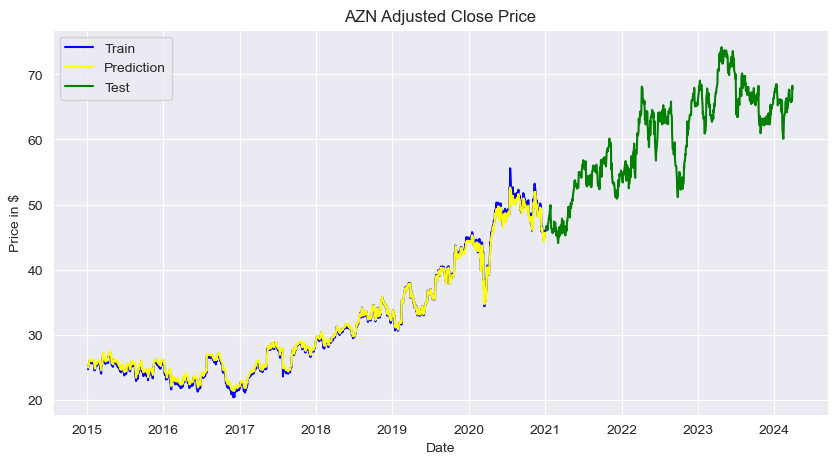

In [28]:
# Prediction on train set
est_scaled = model_AZN.predict(X_train_AZN_scaled)
est = est_scaled * math.sqrt(scaler_train_AZN.var_[0]) + scaler_train_AZN.mean_[0]

plt.figure(figsize=(10, 5))
plt.plot(train_AZN['Date'], train_AZN['Adj Close'], label='Train', color='blue')
plt.plot(train_AZN['Date'], est, label='Prediction', color='yellow')
plt.plot(test_AZN['Date'], test_AZN['Adj Close'], label='Test', color='green')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('AZN Adjusted Close Price')
plt.legend()
plt.show()

In [29]:
# Calculate MSE
mse = mean_squared_error(train_AZN['Adj Close'], est)
print("MSE on the training set = %0.3f" % mse)

MSE on the training set = 0.154


In [30]:
# Scaling the test set
def scale_row(row, feat_mean, feat_std):
    row_scaled = (row-feat_mean) / (feat_std + (feat_std==0)*0.001)
    return row_scaled

In [31]:
test_scaled = test_AZN[['Date']]
for col in cols_list:
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, 4)]
    temp = test_AZN.apply(lambda row: scale_row(row[feat_list], row[col + '_mean'], row[col + '_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)

test_scaled.head()

,Date,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
1508,2021-01-04,-0.893802,-0.186217,-1.228962,0.269291,-1.107071,0.089762,-1.101378,0.250316,2.653322,-1.117733,0.307860,1.436180
1509,2021-01-05,0.316087,-1.119847,-0.605087,1.027313,-0.057071,-2.682458,1.035844,-0.076027,0.693732,0.969195,-1.028192,0.449009
1510,2021-01-06,-0.051221,-0.973405,-3.688739,-0.504886,1.151786,0.252452,-0.868856,1.093076,-0.000004,-0.368329,1.131925,-2.160313
1511,2021-01-07,0.837218,0.270085,-0.216045,0.218200,0.872883,8.510163,-0.198998,-0.885539,1.203927,-1.121344,0.322048,5.800519
1512,2021-01-08,-1.152467,0.638407,0.116086,0.293094,0.820703,1.084524,1.097576,-0.238153,-0.952610,0.857064,0.241603,0.704132


In [32]:
X_test_scaled = test_scaled[features]
# Prediction on validation set
est_scaled = model_AZN.predict(X_test_scaled)
est_AZN = est_scaled * test_AZN['Adj Close_std'] + test_AZN['Adj Close_mean']

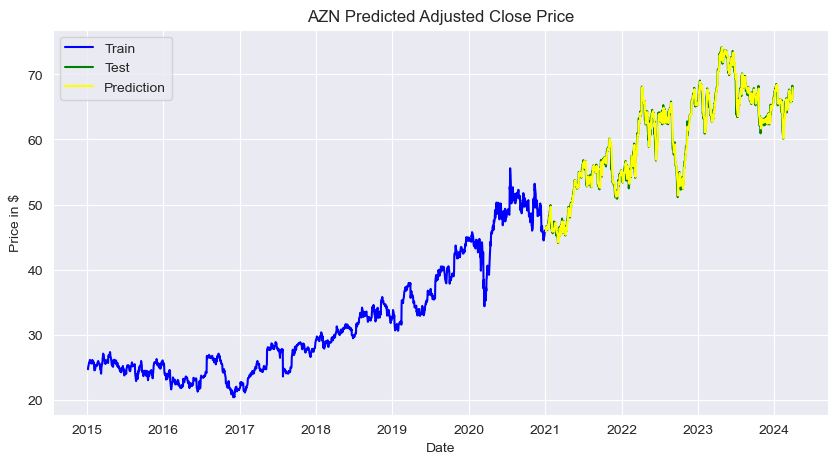

In [33]:
plt.figure(figsize=(10,5))
plt.plot(train_AZN['Date'], train_AZN['Adj Close'], label='Train', color='blue')
plt.plot(test_AZN['Date'], test_AZN['Adj Close'], label='Test', color='green')
plt.plot(test_AZN['Date'], est_AZN, label='Prediction', color='yellow')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('AZN Predicted Adjusted Close Price')
plt.legend()
plt.show()

In [34]:
# Calculate MSE
mse_AZN = mean_squared_error(test_AZN['Adj Close'], est_AZN)
print("MSE on the test set = %0.3f" % mse_AZN)

MSE on the test set = 0.824


#### STEP 4.2: FTNT Prediction Model

We can now repeat the same process with the FTNT stock. 

In [35]:
# Download the AZN data, including Adj Close, Volume, Open, Close, High, and Low
data_FTNT = yf.download('FTNT', start='2015-01-01', end='2024-04-01')

[*********************100%%**********************]  1 of 1 completed


In [36]:
data_FTNT = data_FTNT.reset_index()
data_FTNT.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,6.180,6.238,6.102,6.158,6.158,6307500
1,2015-01-05,6.126,6.198,6.062,6.104,6.104,9120500
2,2015-01-06,6.108,6.152,5.910,5.990,5.990,10918000
3,2015-01-07,6.050,6.132,5.994,6.076,6.076,7066000
4,2015-01-08,6.178,6.296,6.160,6.242,6.242,7181000


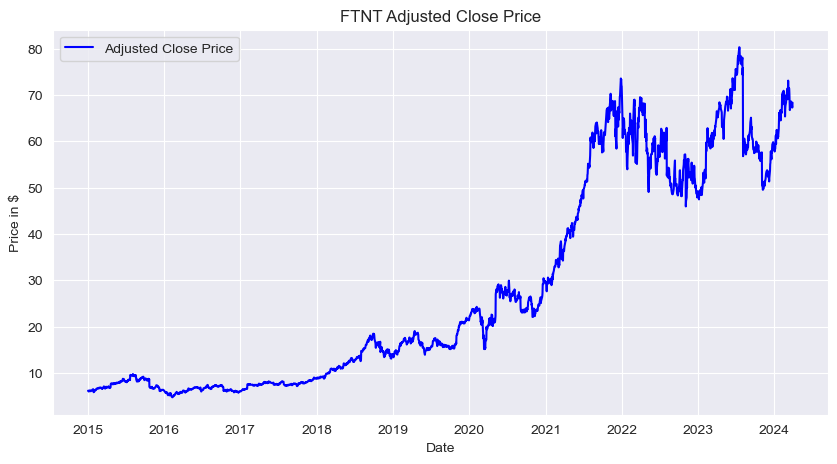

In [37]:
# Plot the data
plt.figure(figsize=(10,5))
plt.plot(data_FTNT['Date'], data_FTNT['Adj Close'], label='Adjusted Close Price', color='blue')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('FTNT Adjusted Close Price')
plt.legend()
plt.show()

In [38]:
# Checking for any missing value in the dataset
missing_values = data_FTNT.isnull().sum()
print(missing_values)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [39]:
# Compute the difference between high and low for each day
data_FTNT['range_hl'] = data_FTNT['High'] - data_FTNT['Low']
# Compute the difference between open and close of each day
data_FTNT['range_oc'] = data_FTNT['Open'] - data_FTNT['Close']
# Add an second index column to create the lags
data_FTNT['Index'] = data_FTNT.index
data_FTNT.drop(['High', 'Low', 'Open', 'Close'], axis=1, inplace=True)
data_FTNT.head()

,Date,Adj Close,Volume,range_hl,range_oc,Index
0,2015-01-02,6.158,6307500,0.136,0.022,0
1,2015-01-05,6.104,9120500,0.136,0.022,1
2,2015-01-06,5.990,10918000,0.242,0.118,2
3,2015-01-07,6.076,7066000,0.138,-0.026,3
4,2015-01-08,6.242,7181000,0.136,-0.064,4


In [40]:
# List of columns that we will use to create lags
lag_cols = ['Adj Close', 'Volume', 'range_hl', 'range_oc']
shift_range = [x + 1 for x in range(3)]

for shift in shift_range:
    train_shift = data_FTNT[['Index'] + lag_cols].copy()

    train_shift['Index'] = train_shift['Index'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    data_FTNT = pd.merge(data_FTNT, train_shift, on='Index', how='left')

del train_shift

# Remove the first 3 rows which contain NaNs
data_FTNT = data_FTNT[3:]
data_FTNT.head()

,Date,Adj Close,Volume,range_hl,range_oc,Index,Adj Close_lag_1,Volume_lag_1,range_hl_lag_1,range_oc_lag_1,Adj Close_lag_2,Volume_lag_2,range_hl_lag_2,range_oc_lag_2,Adj Close_lag_3,Volume_lag_3,range_hl_lag_3,range_oc_lag_3
3,2015-01-07,6.076,7066000,0.138,-0.026,3,5.990,10918000.0,0.242,0.118,6.104,9120500.0,0.136,0.022,6.158,6307500.0,0.136,0.022
4,2015-01-08,6.242,7181000,0.136,-0.064,4,6.076,7066000.0,0.138,-0.026,5.990,10918000.0,0.242,0.118,6.104,9120500.0,0.136,0.022
5,2015-01-09,6.214,6755000,0.122,0.048,5,6.242,7181000.0,0.136,-0.064,6.076,7066000.0,0.138,-0.026,5.990,10918000.0,0.242,0.118
6,2015-01-12,6.168,6461000,0.114,0.074,6,6.214,6755000.0,0.122,0.048,6.242,7181000.0,0.136,-0.064,6.076,7066000.0,0.138,-0.026
7,2015-01-13,6.180,6494000,0.218,0.032,7,6.168,6461000.0,0.114,0.074,6.214,6755000.0,0.122,0.048,6.242,7181000.0,0.136,-0.064


In [41]:
data_FTNT = data_FTNT.reset_index()
data_FTNT.drop(['index', 'Index'], axis=1, inplace=True)
## Add moving average and moving std
cols_list = ["Adj Close", "range_hl", "range_oc", "Volume"]
for col in cols_list:
    data_FTNT[col + '_mean'] = data_FTNT[col].rolling(window=3, min_periods=1, center=False).mean()
    data_FTNT[col + '_std'] = data_FTNT[col].rolling(window=3, min_periods=1, center=False).std()
data_FTNT.head()

,Date,Adj Close,Volume,range_hl,range_oc,Adj Close_lag_1,Volume_lag_1,range_hl_lag_1,range_oc_lag_1,Adj Close_lag_2,...,range_hl_lag_3,range_oc_lag_3,Adj Close_mean,Adj Close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,Volume_mean,Volume_std
0,2015-01-07,6.076,7066000,0.138,-0.026,5.990,10918000.0,0.242,0.118,6.104,...,0.136,0.022,6.076000,NaN,0.138000,NaN,-0.026000,NaN,7.066000e+06,NaN
1,2015-01-08,6.242,7181000,0.136,-0.064,6.076,7066000.0,0.138,-0.026,5.990,...,0.136,0.022,6.159000,0.117380,0.137000,0.001414,-0.045000,0.026870,7.123500e+06,81317.279836
2,2015-01-09,6.214,6755000,0.122,0.048,6.242,7181000.0,0.136,-0.064,6.076,...,0.242,0.118,6.177334,0.088867,0.132000,0.008718,-0.014000,0.056956,7.000667e+06,220386.781213
3,2015-01-12,6.168,6461000,0.114,0.074,6.214,6755000.0,0.122,0.048,6.242,...,0.138,-0.026,6.208000,0.037363,0.124000,0.011135,0.019333,0.073330,6.799000e+06,362011.049555
4,2015-01-13,6.180,6494000,0.218,0.032,6.168,6461000.0,0.114,0.074,6.214,...,0.136,-0.064,6.187333,0.023861,0.151333,0.057873,0.051333,0.021197,6.570000e+06,161062.099825


In [42]:
date = '2021-01-04'
train_end = data_FTNT[data_AZN['Date'] == date].index.item()

# Split the DataFrame
train_FTNT = data_FTNT.iloc[:train_end]
test_FTNT = data_FTNT.iloc[train_end:]

print(f"Train set size: {train_FTNT.shape}")
print(f"Test set size: {test_FTNT.shape}")

Train set size: (1508, 25)
Test set size: (814, 25)


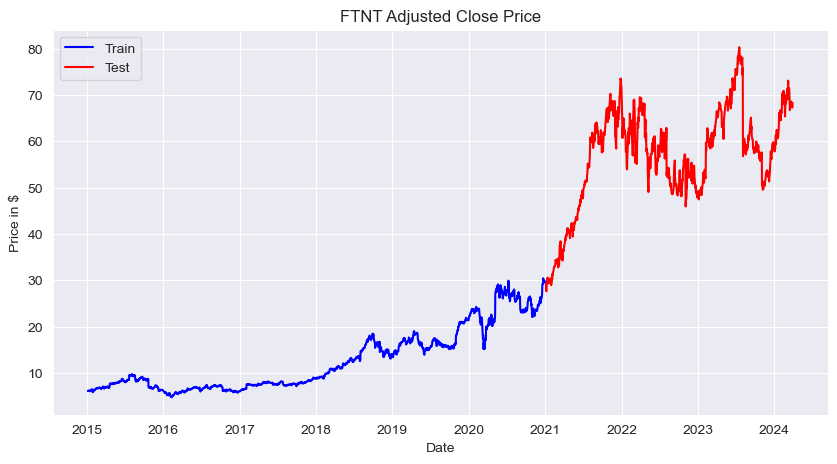

In [43]:
# Plot the data
plt.figure(figsize=(10,5))
plt.plot(train_FTNT['Date'], train_FTNT['Adj Close'], label='Train', color='blue')
plt.plot(test_FTNT['Date'], test_FTNT['Adj Close'], label='Test', color='red')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('FTNT Adjusted Close Price')
plt.legend()
plt.show()

In [44]:
scaler_train_FTNT = StandardScaler()
train_FTNT_scaled = scaler_train_FTNT.fit_transform(train_FTNT[scaled_columns])
train_FTNT_scaled = pd.DataFrame(train_FTNT_scaled, columns=scaled_columns)
train_FTNT_scaled['Date'] = train_FTNT['Date']

train_FTNT_scaled.head()

,Adj Close,Adj Close_lag_1,range_hl_lag_1,range_oc_lag_1,Volume_lag_1,Adj Close_lag_2,range_hl_lag_2,range_oc_lag_2,Volume_lag_2,Adj Close_lag_3,range_hl_lag_3,range_oc_lag_3,Volume_lag_3,Date
0,-0.983624,-0.995903,-0.364057,0.391119,0.255533,-0.978323,-0.657738,0.085050,0.007863,-0.969676,-0.656709,0.086121,-0.379273,2015-01-07
1,-0.958881,-0.983061,-0.652796,-0.068367,-0.274038,-0.995377,-0.363487,0.391395,0.255038,-0.977769,-0.656708,0.086121,0.007602,2015-01-08
2,-0.963055,-0.958273,-0.658348,-0.189620,-0.258228,-0.982512,-0.652187,-0.068122,-0.274652,-0.994853,-0.362313,0.392723,0.254814,2015-01-09
3,-0.969911,-0.962454,-0.697217,0.167757,-0.316794,-0.957679,-0.657738,-0.189384,-0.258838,-0.981965,-0.651154,-0.067179,-0.274956,2015-01-12
4,-0.968123,-0.969323,-0.719427,0.250720,-0.357213,-0.961868,-0.696601,0.168019,-0.317418,-0.957087,-0.656708,-0.188543,-0.259140,2015-01-13


In [45]:
# Split into X and y
X_train_FTNT_scaled = train_FTNT_scaled[features]
y_train_FTNT_scaled = train_FTNT_scaled[target]

X_train_FTNT_scaled.head()

,Adj Close_lag_1,range_hl_lag_1,range_oc_lag_1,Volume_lag_1,Adj Close_lag_2,range_hl_lag_2,range_oc_lag_2,Volume_lag_2,Adj Close_lag_3,range_hl_lag_3,range_oc_lag_3,Volume_lag_3
0,-0.995903,-0.364057,0.391119,0.255533,-0.978323,-0.657738,0.085050,0.007863,-0.969676,-0.656709,0.086121,-0.379273
1,-0.983061,-0.652796,-0.068367,-0.274038,-0.995377,-0.363487,0.391395,0.255038,-0.977769,-0.656708,0.086121,0.007602
2,-0.958273,-0.658348,-0.189620,-0.258228,-0.982512,-0.652187,-0.068122,-0.274652,-0.994853,-0.362313,0.392723,0.254814
3,-0.962454,-0.697217,0.167757,-0.316794,-0.957679,-0.657738,-0.189384,-0.258838,-0.981965,-0.651154,-0.067179,-0.274956
4,-0.969323,-0.719427,0.250720,-0.357213,-0.961868,-0.696601,0.168019,-0.317418,-0.957087,-0.656708,-0.188543,-0.259140


In [46]:
#Define the model
model = XGBRegressor(objective ='reg:squarederror')

# Define the parameters to tune
param_grid = {
    'n_estimators': range(30, 130, 10),
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    #'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'learning_rate': [ 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
}

# Initialize Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')


# Assuming X_train and y_train are your data
grid.fit(X_train_FTNT_scaled, y_train_FTNT_scaled)

# Print the best parameters
print("Best parameters found: ", grid.best_params_)
print("Best MSE score: ", -grid.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 120}
Best MSE score:  0.19448574029993262


In [47]:
model_FTNT = XGBRegressor(n_estimators = 120, max_depth = 2, learning_rate = 0.1,objective ='reg:squarederror')
model_FTNT.fit(X_train_FTNT_scaled, y_train_FTNT_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

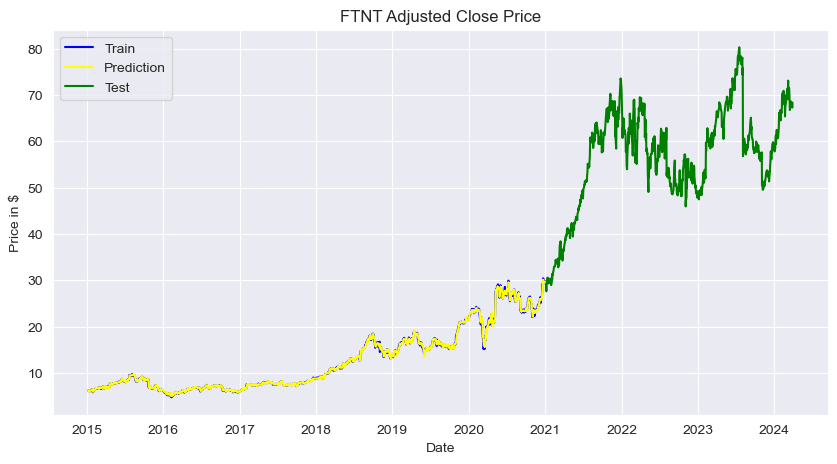

In [48]:
# Prediction on train set
est_scaled = model_FTNT.predict(X_train_FTNT_scaled)
est_FTNT = est_scaled * math.sqrt(scaler_train_FTNT.var_[0]) + scaler_train_FTNT.mean_[0]

plt.figure(figsize=(10, 5))
plt.plot(train_FTNT['Date'], train_FTNT['Adj Close'], label='Train', color='blue')
plt.plot(train_FTNT['Date'], est_FTNT, label='Prediction', color='yellow')
plt.plot(test_FTNT['Date'], test_FTNT['Adj Close'], label='Test', color='green')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('FTNT Adjusted Close Price')
plt.legend()
plt.show()

In [49]:
# Calculate MSE
mse = mean_squared_error(train_FTNT['Adj Close'], est_FTNT)
print("MSE on the training set = %0.3f" % mse)

MSE on the training set = 0.091


In [50]:
test_scaled = test_FTNT[['Date']]
for col in cols_list:
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, 4)]
    temp = test_FTNT.apply(lambda row: scale_row(row[feat_list], row[col + '_mean'], row[col + '_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)

test_scaled.head()

,Date,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,Volume_lag_1,Volume_lag_2,Volume_lag_3
1508,2021-01-04,0.730426,0.409292,0.100751,-0.636533,-0.516071,0.284608,-0.711968,-0.431307,0.410689,-0.769836,-0.360410,-0.125903
1509,2021-01-05,0.083239,0.955779,0.805950,1.129665,-0.771939,-0.643905,1.152481,-0.514271,-0.262125,0.378541,-1.134009,-0.808087
1510,2021-01-06,-0.017000,1.008392,1.805621,-0.678269,1.148433,-1.186974,-0.456682,1.146808,-0.345700,0.194827,-1.083077,-6.211119
1511,2021-01-07,-1.106543,0.267488,1.713438,-0.295086,-0.819252,3.781746,0.427529,0.715167,2.690914,0.069662,-1.033009,-3.065114
1512,2021-01-08,0.016615,-1.008204,-0.284451,0.657600,-1.150792,-1.823335,-0.708234,1.143929,1.483214,1.051933,-0.113561,-1.551601


In [51]:
X_test_scaled = test_scaled[features]
# Prediction on validation set
est_scaled = model_FTNT.predict(X_test_scaled)
est_FTNT = est_scaled * test_FTNT['Adj Close_std'] + test_FTNT['Adj Close_mean']

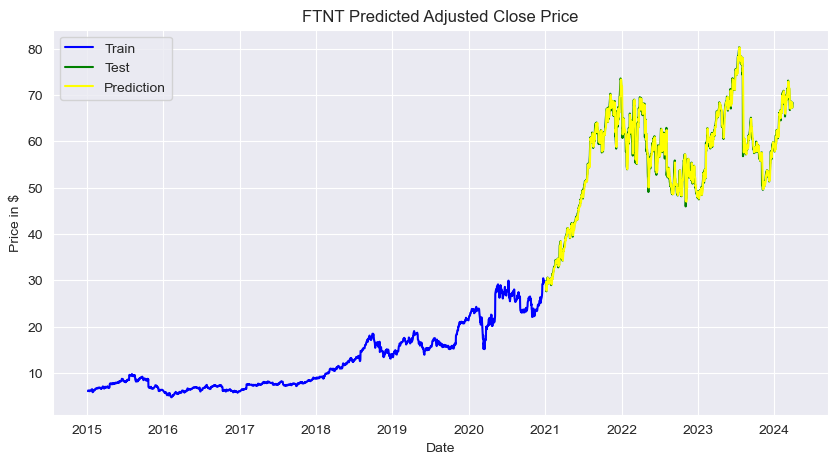

In [52]:
plt.figure(figsize=(10,5))
plt.plot(train_FTNT['Date'], train_FTNT['Adj Close'], label='Train', color='blue')
plt.plot(test_FTNT['Date'], test_FTNT['Adj Close'], label='Test', color='green')
plt.plot(test_FTNT['Date'], est_FTNT, label='Prediction', color='yellow')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('FTNT Predicted Adjusted Close Price')
plt.legend()
plt.show()

In [53]:
# Calculate MSE
mse_FTNT = mean_squared_error(test_FTNT['Adj Close'], est_FTNT)
print("MSE on the test set = %0.3f" % mse_FTNT)

MSE on the test set = 2.726


### STEP 5: Implement the Strategy

In order to implement our strategy, we have select the pair that have the smallest p-value. In this case, we will use 'AZN' and 'FTNT'. We saw that from ‘2015-01-01’ to ‘2021-01-01’, the two were highly cointegrated, let’s see how the strategy would perform using the predicted data from ‘2021-01-01’ to today.

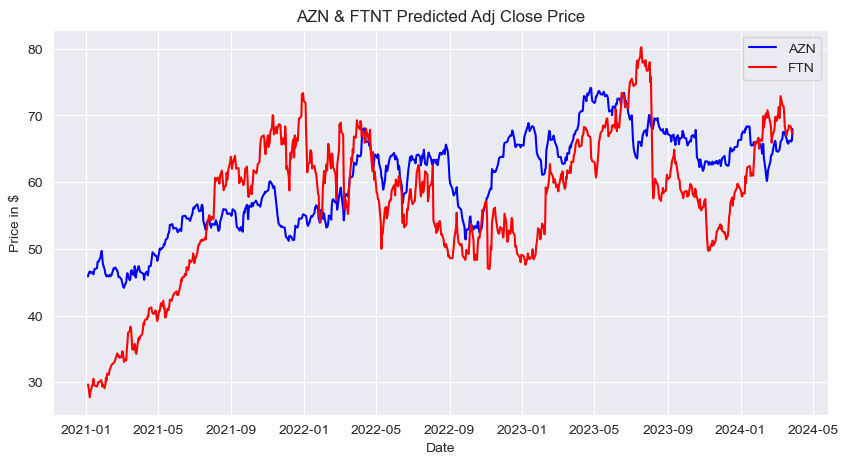

In [54]:
plt.figure(figsize=(10,5))

plt.plot(test_AZN['Date'], est_AZN, label='AZN', color='blue')
plt.plot(test_FTNT['Date'], est_FTNT, label='FTN', color='red')
plt.title('AZN & FTNT Predicted Adj Close Price')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.legend()
plt.show()

We will create trading signals using the Z-score and mean with a rolling window, so don't have to split into training and test sets. The Z-score is denoted as:
 $$ Z = \frac{X - \mu}{\sigma}$$ 

- $X$ is the price we want to standardize.
- $\mu$ is the mean of the rolling window.
- $\sigma$ is the standard deviation of the rolling window.

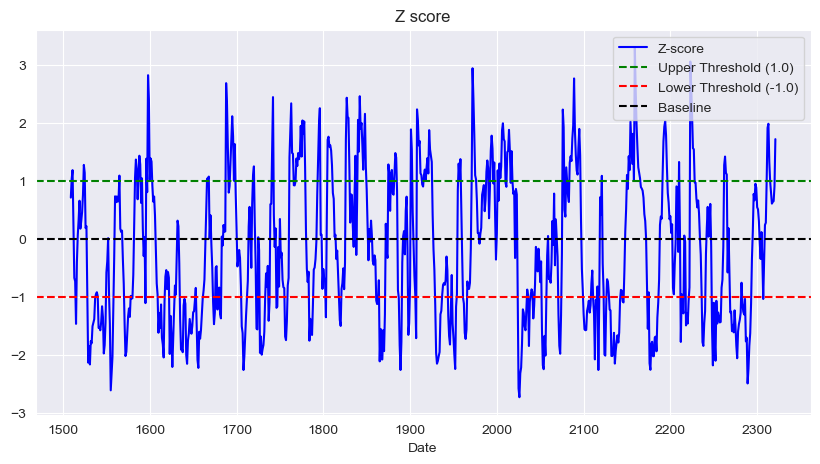

In [55]:
ratios = est_AZN/est_FTNT
mean_ratios = ratios.rolling(window=15, min_periods=1, center=False).mean()
std_ratios = ratios.rolling(window=15, min_periods=1, center=False).std()

zscore = (ratios - mean_ratios)/std_ratios

plt.figure(figsize=(10,5))
plt.plot(zscore, label='Z-score', color='blue')
plt.axhline(1.0, color="green", linestyle='--', label="Upper Threshold (1.0)")
plt.axhline(-1.0, color="red", linestyle='--', label="Lower Threshold (-1.0)")
plt.axhline(0, color="black", linestyle='--', label="Baseline")
plt.title('Z score')
plt.xlabel('Date')
plt.legend()
plt.show()

**Generate buy and sell signals**

When the Z-score surpasses a predefined threshold, it generates a trading signal. If the Z-score goes above +1, it indicates that one asset is overvalued compared to the other, signaling a sell for the overvalued asset and a buy for the undervalued one.

In [56]:
def generate_signals(data1, data2, up_threshold = 1, down_threshold = -1):
    
    ratios = data1/data2
    mean_ratios = ratios.rolling(window=15, min_periods=1, center=False).mean()
    std_ratios = ratios.rolling(window=15, min_periods=1, center=False).std()
    
    zscore = (ratios - mean_ratios)/std_ratios
    
    buy1 = ratios.copy()
    sell1 = ratios.copy()
    buy2 = ratios.copy()
    sell2 =ratios.copy()
    
    # Signal for the 1st ticker
    buy1[zscore > down_threshold] = 0
    sell1[zscore < up_threshold] = 0
    
    # Signal for the 2nd ticker
    buy2[zscore < down_threshold] = 0
    sell2[zscore > up_threshold] = 0
    
    signals1 = pd.DataFrame(index=ratios.index)
    signals1['signal'] = np.where(buy1 > 0, 1, np.where(sell1 < 0, -1, 0))
    signals1['orders'] = signals1['signal'].diff()
    signals1.loc[signals1['orders'] == 0, 'orders'] = None
    
    signals2 = pd.DataFrame(index=ratios.index)
    signals2['signal'] = np.where(buy2 > 0, 1, np.where(sell2 < 0, -1, 0))
    signals2['orders'] = signals2['signal'].diff()
    signals2.loc[signals2['orders'] == 0, 'orders'] = None
    
    return signals1, signals2

In [57]:
def calculate_profit(signals, prices):

    profit = pd.Series(index=prices.index, dtype = 'float64')
    profit.fillna(0, inplace=True)

    buys = signals[signals['orders'] == 1].index
    sells = signals[signals['orders'] == -1].index
    skip = 0
    for bi in buys:
        if skip > 0:
            skip -= 1
            continue
        sis = sells[sells > bi]
        if len(sis) > 0:
            si = sis[0]
            profit[si] = prices[si] - prices[bi]
            skip = len(buys[(buys > bi) & (buys < si)])
        else:
            profit[-1] = prices.to_list()[-1] - prices[bi]
    cum_profit = profit.cumsum()

    return cum_profit

In [58]:
def plot_strategy(prices, signal, profit):

    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': (3, 1)},
                                   figsize=(24, 12))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price in $')
    ax1.plot(prices.index, prices, color='g', lw=0.25)

    # Plot the Buy and Sell signals
    ax1.plot(signal.loc[signal.orders == 1.0].index,
             prices[signal.orders == 1.0],
             '^', color='blue', label='Buy')
    ax1.plot(signal.loc[signal.orders == -1.0].index,
             prices[signal.orders == -1.0],
             'v', color='red', label='Sell')

    ax2.plot(profit.index, profit, color='b')
    ax2.set_ylabel('Cumulative Profit (%)')
    ax2.set_xlabel('Date')

    return ax1, ax2

In [59]:
# Retrieve the signals
signals_AZN, signals_FTNT = generate_signals(est_AZN, est_FTNT)
signals_AZN.index = test_AZN['Date']
signals_FTNT.index = test_FTNT['Date']

In [60]:
prices_AZN = test_AZN[['Adj Close', 'Volume']].set_index(test_AZN['Date'])
prices_FTNT = test_FTNT[['Adj Close', 'Volume']].set_index(test_FTNT['Date'])

<Figure size 2600x1800 with 0 Axes>

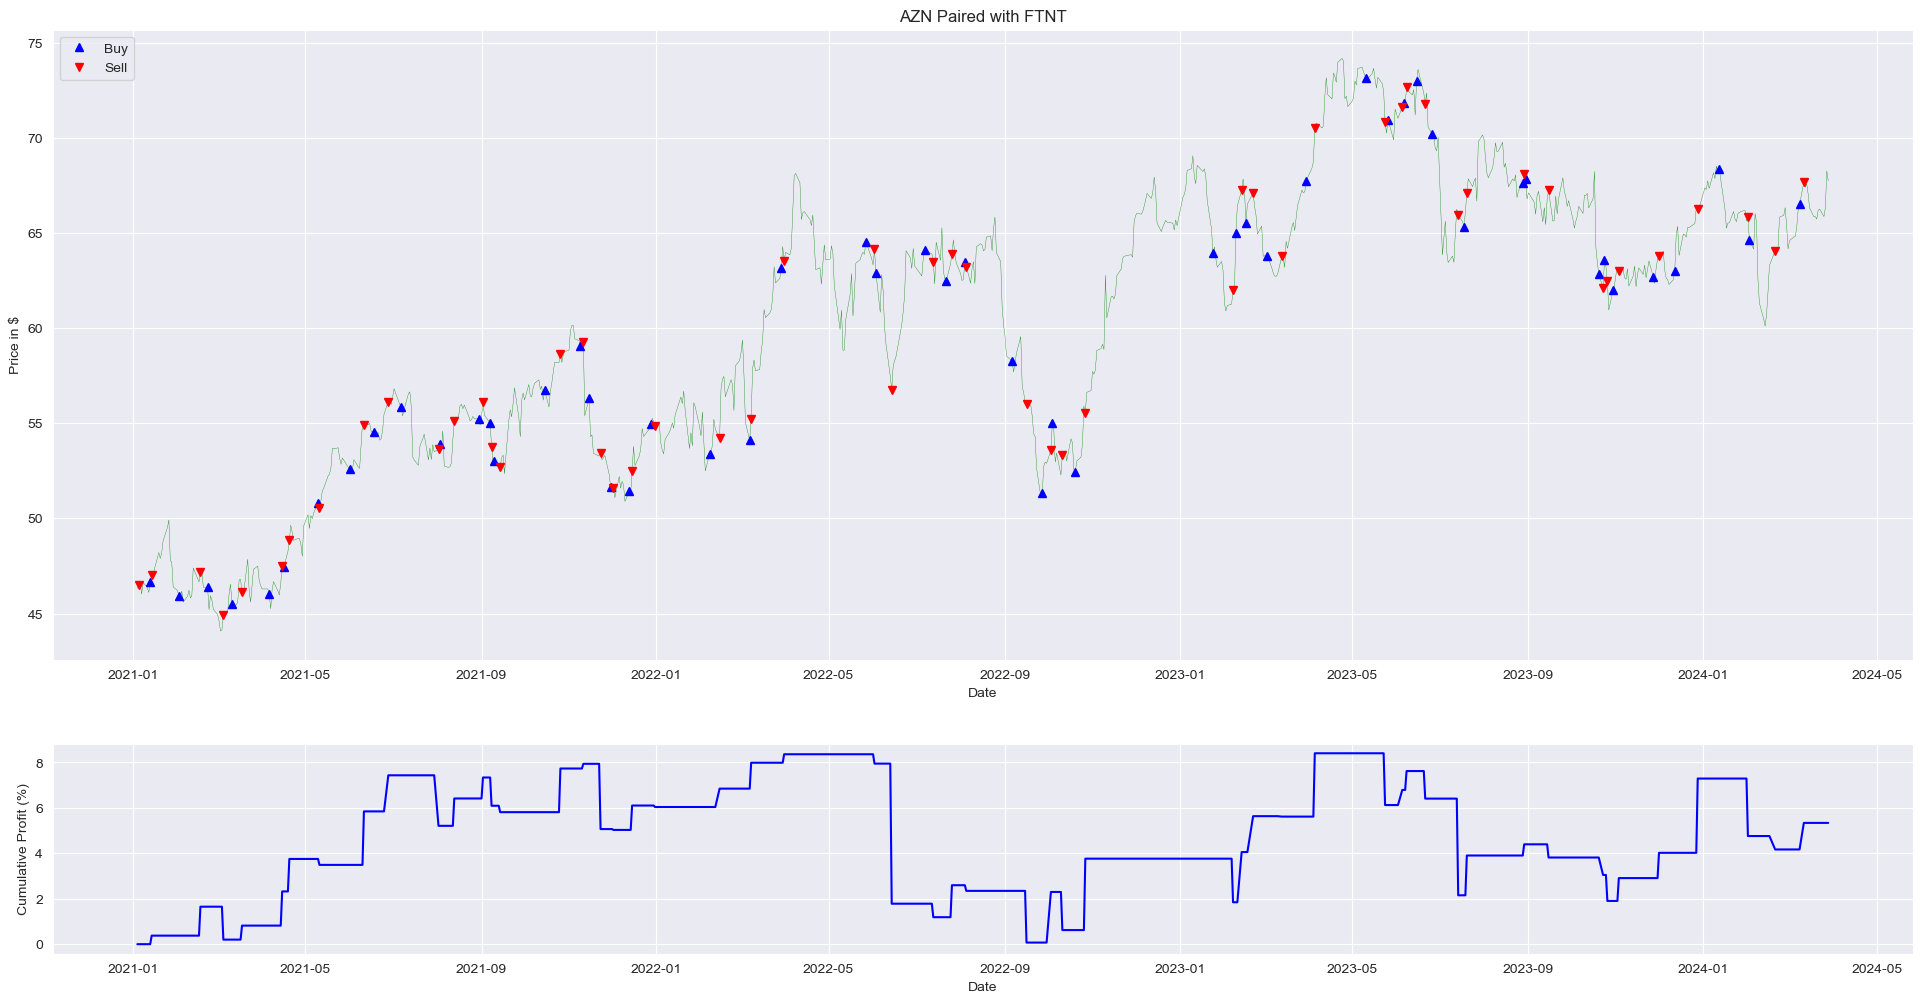

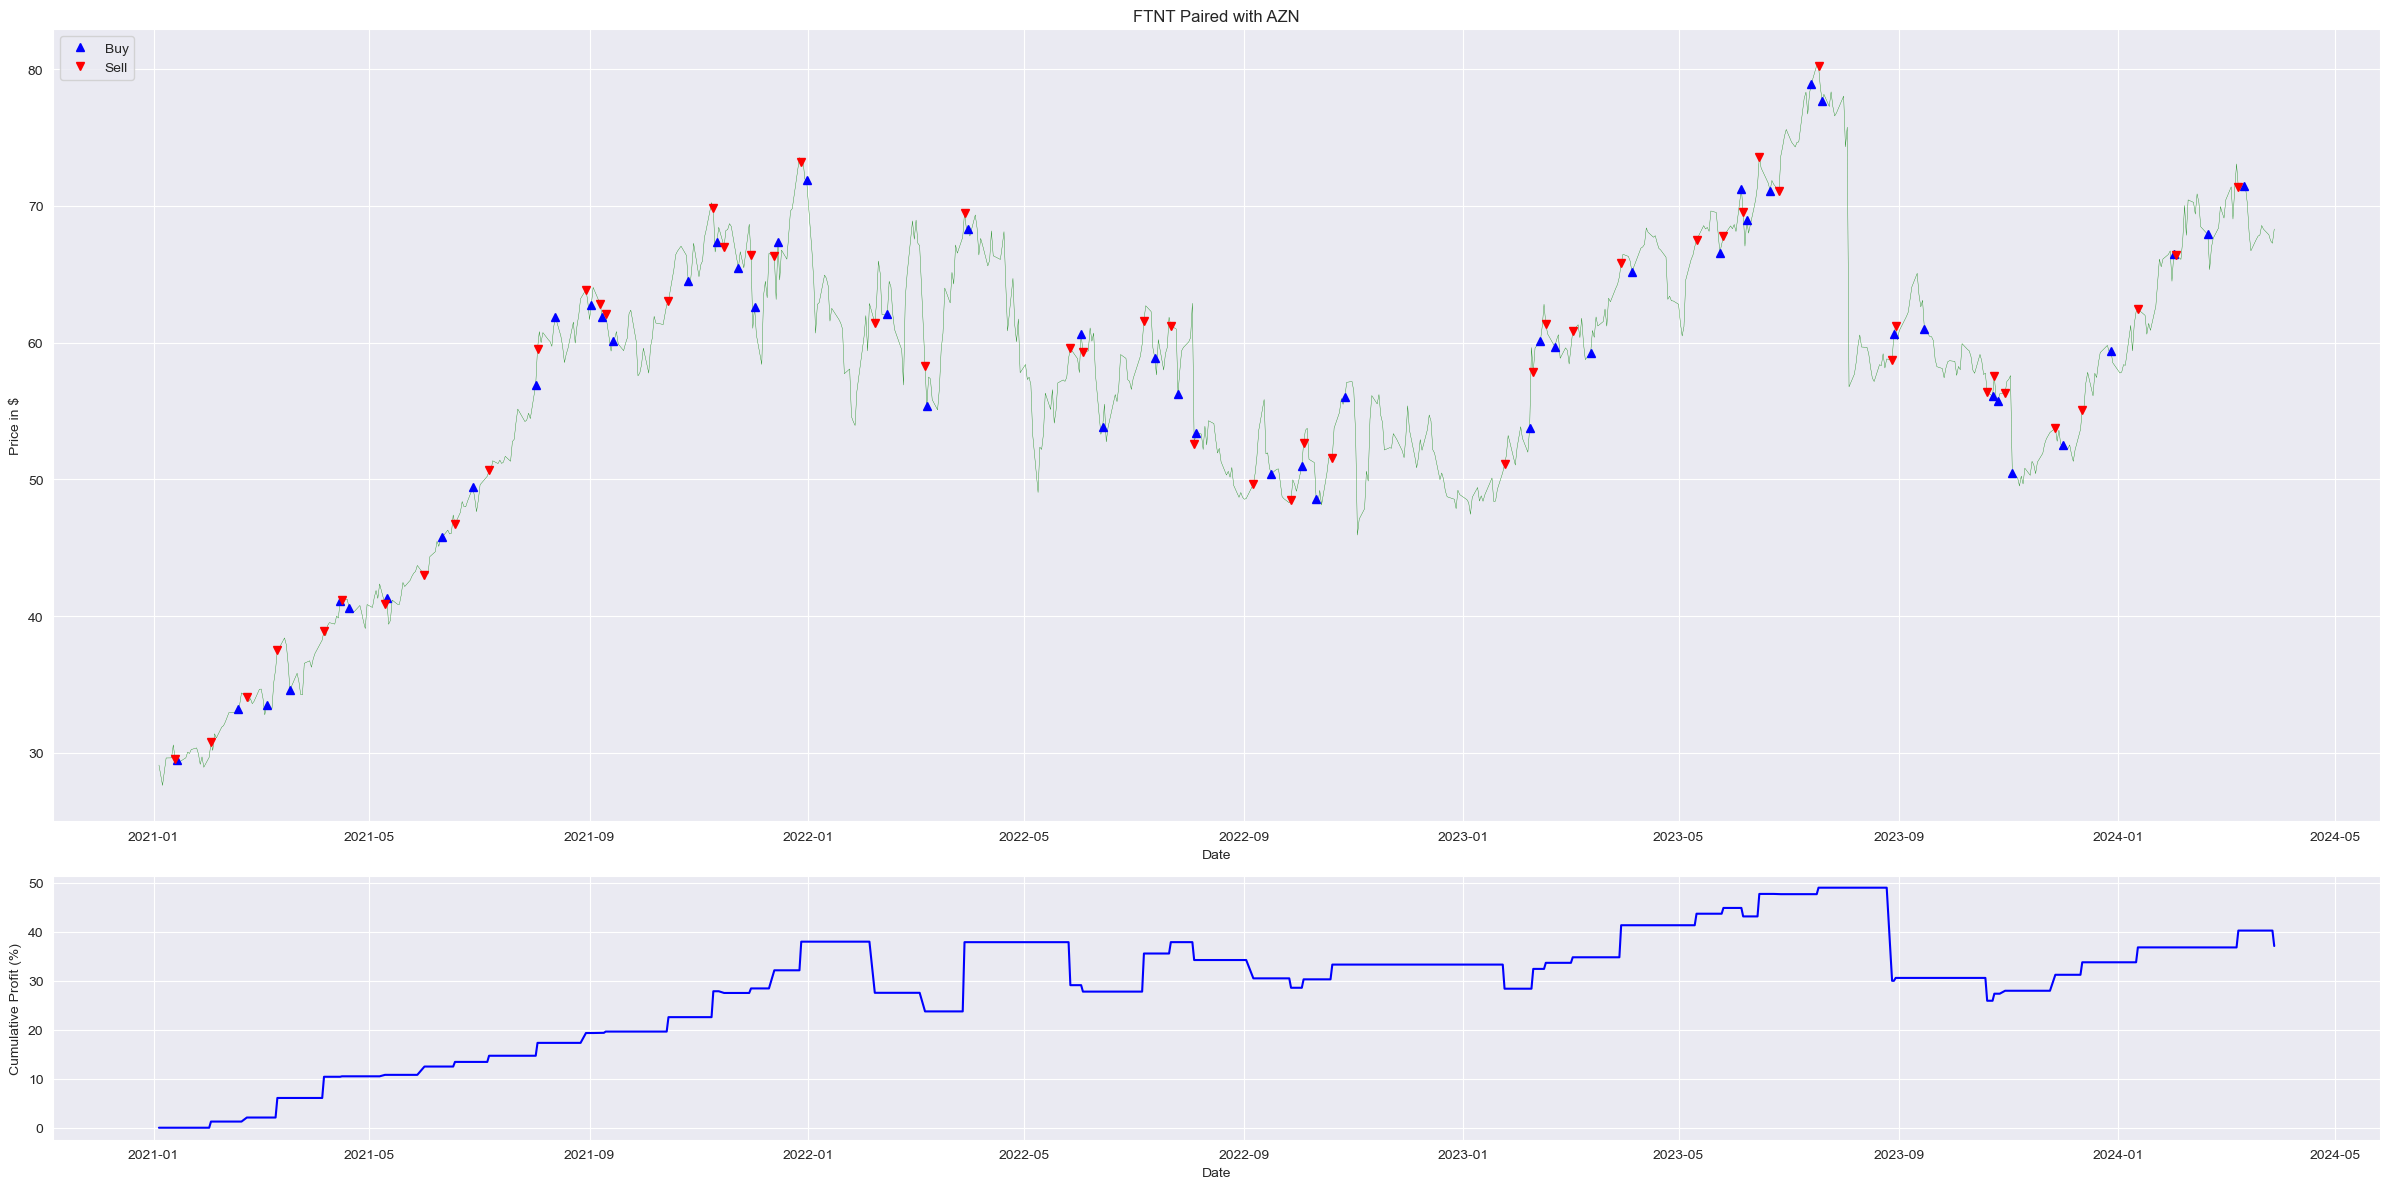

In [61]:
# Plot the results
plt.figure(figsize=(26, 18))
profit_AZN = calculate_profit(signals_AZN, prices_AZN['Adj Close'])
ax1, _ = plot_strategy(prices_AZN['Adj Close'], signals_AZN, profit_AZN)

profit_FTNT = calculate_profit(signals_FTNT, prices_FTNT['Adj Close'])
ax2, _ = plot_strategy(prices_FTNT['Adj Close'], signals_FTNT, profit_FTNT)

ax1.legend(loc='upper left')
ax1.set_title('AZN Paired with FTNT')
ax2.legend(loc='upper left')
ax2.set_title('FTNT Paired with AZN')
plt.tight_layout()
plt.show()

In a portfolio, the two strategies would be uses together, thus it makes sense to represent the cumulative return of the overall strategy as the sum of the two of them.

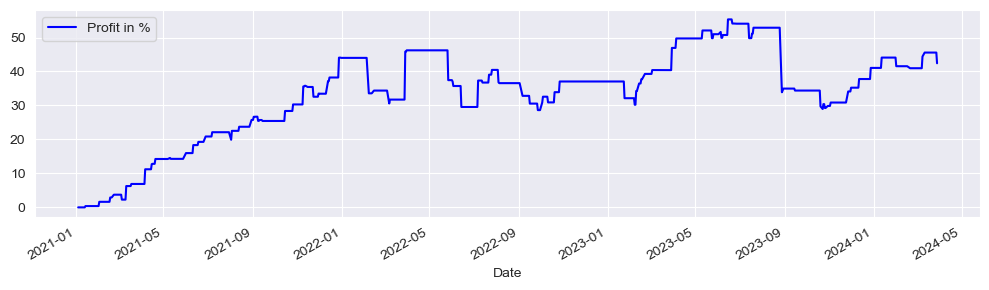

In [62]:
plt.figure(figsize=(10, 3))
cumulative_profit = profit_AZN + profit_FTNT
ax_combined = cumulative_profit.plot(label='Profit in %', color='blue')
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()